<a href="https://colab.research.google.com/github/zosiak00/uczenie_maszynowe_ZK/blob/case2/Case2_ZK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

In [4]:
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
ratings = pd.read_csv('https://s3-us-west-2.amazonaws.com/recommender-tutorial/ratings.csv')
movies = pd.read_csv('https://s3-us-west-2.amazonaws.com/recommender-tutorial/movies.csv')

1. Przegląd danych:

In [6]:
# zad 1.
SciFi_movies = movies[movies['genres'].str.contains('Sci-Fi')]
SciFi_movies.head()

,movieId,title,genres
23,24,Powder (1995),Drama|Sci-Fi
28,29,"City of Lost Children, The (Cité des enfants p...",Adventure|Drama|Fantasy|Mystery|Sci-Fi
31,32,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller
59,66,Lawnmower Man 2: Beyond Cyberspace (1996),Action|Sci-Fi|Thriller
68,76,Screamers (1995),Action|Sci-Fi|Thriller


In [7]:
SciFi_movies_number = SciFi_movies['movieId'].count()
print(f"Odpowiedź do zad. 1.1: \n W bazie znajduje się {SciFi_movies_number} filmów Sci-Fi.")

Odpowiedź do zad. 1.1: 
 W bazie znajduje się 980 filmów Sci-Fi.


In [8]:
movies_rates=pd.merge(movies[["movieId", "title", 'genres']], ratings[['movieId', 'rating']], left_on="movieId", right_on="movieId")

movies_names = movies_rates[["movieId", "title"]].drop_duplicates()
movies_names[['title', 'year']] = movies_names['title'].str.split(' \(', n=1, expand=True)
movies_names['year'] = movies_names['year'].str.rstrip(')')

# tworzenie słowników
Movies= {row['title']: row['movieId'] for _, row in movies_names.iterrows()}
Ids= {row['movieId']: row['title'] for _, row in movies_names.iterrows()}

In [9]:
comedies_ratings=movies_rates[movies_rates["genres"].str.contains("Comedy")][["rating"]]
comedies_ratings

,rating
0,4.0
1,4.0
2,4.5
3,2.5
4,4.5
...,...
100826,3.5
100828,4.0
100831,4.0
100832,3.5


Odpowiedź do zad. 1.2: 



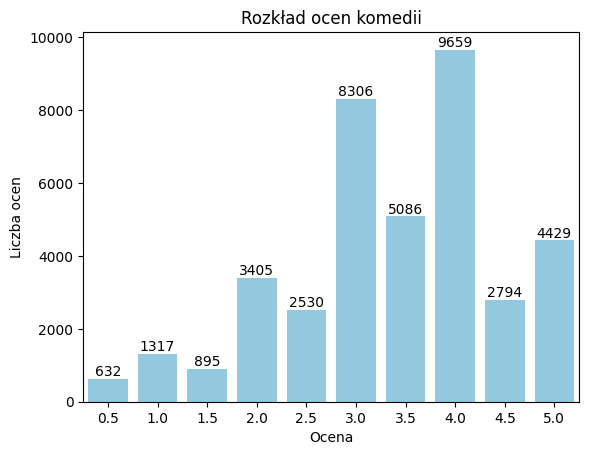

In [10]:
ax=sns.countplot(comedies_ratings, x="rating", color='skyblue')
plt.title("Rozkład ocen komedii")

# Dodawanie etykiet nad słupkami
for p in plt.gca().patches:
    plt.annotate(f'{int(p.get_height())}',
                 (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center',
                 xytext=(0, 5), textcoords='offset points')
ax.set(xlabel='Ocena', ylabel='Liczba ocen')
print("Odpowiedź do zad. 1.2: \n")
plt.show()

In [11]:
# drugi sposób z wykorzystaniem  pakietu matplotlib
rozkład_ocen = comedies_ratings['rating'].value_counts().sort_index()
print(rozkład_ocen)

rating
0.5     632
1.0    1317
1.5     895
2.0    3405
2.5    2530
3.0    8306
3.5    5086
4.0    9659
4.5    2794
5.0    4429
Name: count, dtype: int64


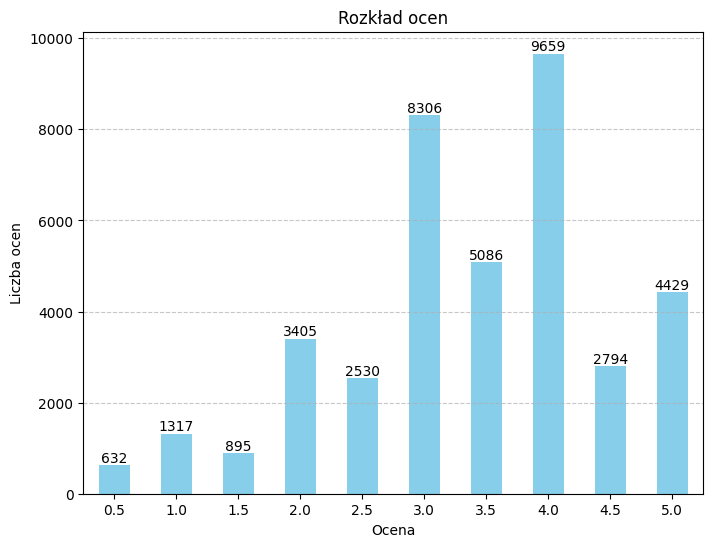

In [12]:
plt.figure(figsize=(8, 6))
rozkład_ocen.plot(kind='bar', color='skyblue')
plt.title('Rozkład ocen')
plt.xlabel('Ocena')
plt.ylabel('Liczba ocen')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
for i in range(len(rozkład_ocen)):
    plt.text(i, rozkład_ocen.iloc[i], str(rozkład_ocen.iloc[i]), ha='center', va='bottom')

plt.show()


In [ ]:
action_ratings = movies_rates[movies_rates['genres'].str.contains('Action')]
action_ratings.head()

,movieId,title,genres,rating
433,6,Heat (1995),Action|Crime|Thriller,4.0
434,6,Heat (1995),Action|Crime|Thriller,4.0
435,6,Heat (1995),Action|Crime|Thriller,5.0
436,6,Heat (1995),Action|Crime|Thriller,4.0
437,6,Heat (1995),Action|Crime|Thriller,4.0


In [ ]:
action_avgScore=action_ratings['rating'].mean()
print(f"Odpowiedź do zad. 1.3: \n Średnia ocena wszystkich filmów akcji wynosi {action_avgScore:.2f}.")

Odpowiedź do zad. 1.3: 
 Średnia ocena wszystkich filmów akcji wynosi 3.45.


In [ ]:
action_stats=action_ratings.groupby(['movieId', 'title'])['rating'].agg(["count", "mean"]).sort_values(by='mean', ascending=False)
action_stats.head()
#print(action_stats[action_stats['movieId'] == 2959])

,,count,mean
movieId,title,,
72142,Love Exposure (Ai No Mukidashi) (2008),1,5.0
138632,Tokyo Tribe (2014),1,5.0
115727,Crippled Avengers (Can que) (Return of the 5 Deadly Venoms) (1981),1,5.0
109241,On the Other Side of the Tracks (De l'autre côté du périph) (2012),1,5.0
108795,Wonder Woman (2009),1,5.0


In [ ]:
movies_rates=pd.merge(movies[["movieId", "title", 'genres']], ratings[['movieId', 'rating']], left_on="movieId", right_on="movieId")
action_stats=action_ratings.groupby(['movieId', 'title'])['rating'].agg(["count", "mean"])
C = action_stats['count'].mean()
m = action_stats['mean'].mean()
def bayesian_avg(ratings):
    bayesian_avg = (C*m+ratings.sum())/(C+ratings.count())
    return bayesian_avg

avg_ratings = action_ratings.groupby('movieId')['rating'].agg(bayesian_avg).reset_index()
avg_ratings.columns = ['movieId', 'bayesian_avg']
action_stats_ratings = action_stats.merge(avg_ratings, on='movieId')
action_stats_ratings=movies_rates[['movieId',	'title']].merge(action_stats_ratings, on='movieId').drop_duplicates()
action_stats_ratings.sort_values(by="bayesian_avg", ascending=False, inplace=True)

best_three=list(action_stats_ratings["title"][:3])
print(f"Najlepsze filmy akcji to \n 1. {best_three[0]}, \n 2. {best_three[1]} \n 3. {best_three[2]}")
best_three_avg = np.mean(action_stats_ratings["mean"][:3])
print(f"Średnia ocena tych 3 filmów wynosi: {best_three_avg:.2f}")

Najlepsze filmy akcji to 
 1. Fight Club (1999), 
 2. Star Wars: Episode IV - A New Hope (1977) 
 3. Star Wars: Episode V - The Empire Strikes Back (1980)
Średnia ocena tych 3 filmów wynosi: 4.24


In [ ]:
action_ratings = movies_rates[movies_rates['genres'].str.contains('Action')]
action_stats=action_ratings.groupby(['movieId', 'title'])['rating'].agg(["count", "mean"])
C = action_stats['count'].mean()
m = action_stats['mean'].mean()
def bayesian_avg(ratings):
    bayesian_avg = (C*m+ratings.sum())/(C+ratings.count())
    return bayesian_avg

bayesian_avg_ratings = action_ratings.groupby('movieId')['rating'].agg(bayesian_avg).reset_index()
bayesian_avg_ratings.columns = ['movieId', 'bayesian_avg']
action_stats_with_bayes = action_stats.merge(bayesian_avg_ratings, on='movieId')
action_stats_with_bayes=movies_rates[['movieId',	'title']].merge(action_stats_with_bayes, on='movieId').drop_duplicates()
action_stats_with_bayes.sort_values(by="bayesian_avg", ascending=False, inplace=True)
best_three=list(action_stats_with_bayes["title"][:3])
print(f"Najlepsze filmy akcji wg średniej bayesowskiej to \n 1. {best_three[0]}, \n 2. {best_three[1]} \n 3. {best_three[2]} ")
best_three_avg = np.mean(action_stats_with_bayes["bayesian_avg"][:3])
print(f"Średnia bayesowska ocen tych 3 filmów wynosi: {best_three_avg:.3f}")

Najlepsze filmy akcji wg średniej bayesowskiej to 
 1. Fight Club (1999), 
 2. Star Wars: Episode IV - A New Hope (1977) 
 3. Star Wars: Episode V - The Empire Strikes Back (1980) 
Średnia bayesowska ocen tych 3 filmów wynosi: 4.161


In [ ]:
action_stats_with_bayes.head()

,movieId,title,count,mean,bayesian_avg
14652,2959,Fight Club (1999),218,4.272936,4.188811
1901,260,Star Wars: Episode IV - A New Hope (1977),251,4.231076,4.159938
6664,1196,Star Wars: Episode V - The Empire Strikes Back...,211,4.215640,4.133145
12929,2571,"Matrix, The (1999)",278,4.192446,4.130021
25064,58559,"Dark Knight, The (2008)",149,4.238255,4.122617


**2. Systemy rekomendacyjne**




In [ ]:
pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 9.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3162995 sha256=930fb84150da4fbc21442d599131a5e7459b8c1ca8019990ba50a23cfe08acc3
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [ ]:
from surprise import Dataset, Reader
from surprise.model_selection import GridSearchCV, cross_validate
from surprise import SVD, KNNWithMeans
from surprise.prediction_algorithms import SVD, KNNBasic, KNNBaseline
from surprise.prediction_algorithms.knns import KNNWithMeans

In [ ]:
def create_sparse(df):
    M = df['userId'].nunique()
    N = df['movieId'].nunique()
    user_mapper = dict(zip(np.unique(df["userId"]), list(range(M))))
    movie_mapper = dict(zip(np.unique(df["movieId"]), list(range(N))))
    user_inv_mapper = dict(zip(list(range(M)), np.unique(df["userId"])))
    movie_inv_mapper = dict(zip(list(range(N)), np.unique(df["movieId"])))
    user_index = [user_mapper[i] for i in df['userId']]
    item_index = [movie_mapper[i] for i in df['movieId']]
    X = csr_matrix((df["rating"], (user_index, item_index)), shape=(M,N))
    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper

In [ ]:
min_rating = ratings.rating.min()
max_rating = ratings.rating.max()

reader = Reader(rating_scale=(min_rating, max_rating))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

In [ ]:
modelSVD = SVD()
cross_validate(modelSVD, data, measures=['RMSE', 'MAE'], cv=5, verbose=True);

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8763  0.8778  0.8662  0.8792  0.8686  0.8736  0.0052  
MAE (testset)     0.6728  0.6738  0.6664  0.6736  0.6682  0.6710  0.0031  
Fit time          1.60    1.58    1.81    2.98    3.73    2.34    0.87    
Test time         0.12    0.17    0.27    0.44    0.19    0.24    0.11    


In [ ]:
from surprise.model_selection import train_test_split
from surprise import accuracy

data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)
modelSVD.fit(trainset)

# Dokonaj predykcji ocen dla danych testowych
predictions = modelSVD.test(testset)

# Wyświetl wyniki predykcji
for uid, iid, true_r, est, _ in predictions[:10]:
    print(f"Użytkownik {uid} ocenił film {iid} na {true_r} punktów, a model przewidział ocenę na {round(est, 2)} punktów.")

# Oceń dokładność modelu
accuracy.rmse(predictions)

Użytkownik 140 ocenił film 6765 na 3.5 punktów, a model przewidział ocenę na 3.36 punktów.
Użytkownik 603 ocenił film 290 na 4.0 punktów, a model przewidział ocenę na 3.57 punktów.
Użytkownik 438 ocenił film 5055 na 4.0 punktów, a model przewidział ocenę na 2.85 punktów.
Użytkownik 433 ocenił film 164179 na 5.0 punktów, a model przewidział ocenę na 3.59 punktów.
Użytkownik 474 ocenił film 5114 na 4.0 punktów, a model przewidział ocenę na 3.32 punktów.
Użytkownik 304 ocenił film 1035 na 4.0 punktów, a model przewidział ocenę na 4.36 punktów.
Użytkownik 298 ocenił film 4974 na 1.0 punktów, a model przewidział ocenę na 2.04 punktów.
Użytkownik 131 ocenił film 293 na 4.0 punktów, a model przewidział ocenę na 3.53 punktów.
Użytkownik 288 ocenił film 5784 na 2.5 punktów, a model przewidział ocenę na 2.69 punktów.
Użytkownik 448 ocenił film 97225 na 2.5 punktów, a model przewidział ocenę na 2.64 punktów.
RMSE: 0.8780


0.8780261244894548

In [ ]:
from sklearn.neighbors import NearestNeighbors

def find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, k, metric='cosine'):
  X = X.T
  neighbour_ids = []
  movie_ind = movie_mapper[movie_id]
  movie_vec = X[movie_ind]
  k+=1
  kNN = NearestNeighbors(n_neighbors=k+1, algorithm="brute", metric=metric)
  kNN.fit(X)
  if isinstance(movie_vec, (np.ndarray)):
      movie_vec = movie_vec.reshape(1,-1)
  neighbour = kNN.kneighbors(movie_vec, return_distance=False)
  for i in range(0,k):
    n = neighbour.item(i)
    neighbour_ids.append(movie_inv_mapper[n])
  neighbour_ids.pop(0)
  return neighbour_ids

Algorytmy **k-Nearest Neighbors (kNN) with Means** oraz standardowy **k-Nearest Neighbors (kNN)** różnią się głównie w sposobie obliczania podobieństwa między użytkownikami lub przedmiotami.

W standardowym kNN podobieństwo między dwoma obiektami (np. użytkownikami) jest obliczane na podstawie odległości między nimi w przestrzeni cech. Najczęściej używaną miarą odległości jest odległość euklidesowa. Obliczane jest podobieństwo między użytkownikami na podstawie ich ocen dla tych samych filmów. Im bliżej są do siebie w przestrzeni ocen, tym bardziej są uznawani za podobnych. Algorytm kNN w standardowej wersji wybiera k najbliższych sąsiadów (użytkowników lub przedmiotów) i na ich podstawie dokonuje rekomendacji.

Algorytm kNN with Means rozszerza standardowy kNN o uwzględnienie średnich ocen użytkowników lub przedmiotów.
Zamiast opierać się wyłącznie na odległościach między obiektami, kNN with Means dodatkowo uwzględnia wartości średnie ocen. Podczas obliczania podobieństwa między obiektami, algorytm uwzględnia także różnice między ich średnimi ocenami tzn. jeśli dwóch użytkowników ma podobne oceny dla wielu filmów, ale jeden z nich ma znacznie wyższą średnią ocen, to kNN with Means może zauważyć tę różnicę i uwzględnić ją w procesie rekomendacji.

In [ ]:
X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper=create_sparse(ratings)
n_total = X.shape[0] * X.shape[1]
n_ratings = X.nnz  # scipy.sparse.csr_matrix.nnz no of stored values, including explicit 0
sparsity = n_ratings / n_total
sparsity_p = round(sparsity * 100, 2)  # Poprawna składnia dla f-string
print(f"Matrix sparsity: {sparsity_p}%")

n_ratings_per_user = X.getnnz(axis=1)

Matrix sparsity: 1.7%


In [ ]:
# Hiperparametryzacja GridSearch do wyboru liczby sąsiadów k:
k_values = {'k': [2, 3, 4, 5, 6]}
knn_with_means = KNNWithMeans(sim_options={'name': 'pearson', 'user_based': False})
cv_knn_means = cross_validate(knn_with_means, data, measures=['RMSE'], cv=5, n_jobs=-1)
results_for_best_k = pd.DataFrame({'k': k_values['k'], 'RMSE': cv_knn_means['test_rmse']})

In [ ]:
results_for_best_k

,k,RMSE
0,2,0.897527
1,3,0.902294
2,4,0.899904
3,5,0.906869
4,6,0.913918


In [ ]:
print("Optymalna liczba sąsiadów k wynosi 4")

Optymalna liczba sąsiadów k wynosi 4


In [ ]:
trainset = data.build_full_trainset()
knn_with_means.fit(trainset)

Computing the pearson similarity matrix...
Done computing similarity matrix.


Pozyskiwanie rekomendacji dla filmów "Jumanji" oraz "Flint":

In [ ]:
def findRecommendations(chosen_id):
  movie_inner_id = knn_with_means.trainset.to_inner_iid(chosen_id)
  recomm_ids = knn_with_means.get_neighbors(movie_inner_id, k=6)
  recomm_raw_ids = [knn_with_means.trainset.to_raw_iid(movie_inner_id) for movie_inner_id in recomm_ids]
  for movie_id in recomm_raw_ids:
    print("'"+Ids[movie_id]+"'")

In [ ]:
chosen_title="Jumanji"
chosen_id= Movies[chosen_title]
print(f"Rekomendowane filmy po obejrzeniu filmu {chosen_title}:")
findRecommendations(chosen_id)

Rekomendowane filmy po obejrzeniu filmu Jumanji:
'Return to Oz'
'Transformers: The Movie'
'Buffalo '66'
'Boys from Brazil, The'
'Before Night Falls'
'Eye for an Eye'


In [ ]:
chosen_title="Flint"
chosen_id= Movies[chosen_title]
print(f"Rekomendowane filmy po obejrzeniu filmu {chosen_title}:")
findRecommendations(chosen_id)

Rekomendowane filmy po obejrzeniu filmu Flint:
'Toy Story'
'Grumpier Old Men'
'Heat'
'Seven'
'Usual Suspects, The'
'From Dusk Till Dawn'
